In [1]:
import chess.svg
import einops
from pathlib import Path
import torch

from chess_gnn.tokenizers import SimpleChessTokenizer
from chess_gnn.models import ChessTransformer
from chess_gnn.utils import PGNBoardHelper

In [2]:
ckpt = torch.load('/Users/ray/models/chess/transformer/a729772e-2fce-4d30-967a-21c11be89ce9/last.ckpt', map_location="cpu")
model = ChessTransformer(**ckpt['hyper_parameters'])
model.load_state_dict(ckpt['state_dict'])


/var/folders/x0/rmp25fy116j6q3pcyk4sbg6w0000gn/T/ipykernel_14360/3077683699.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('/Users/ray/models/chess/tr

<All keys matched successfully>

In [3]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
SimpleChessTokenizer().vocab

['.', 'B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r']

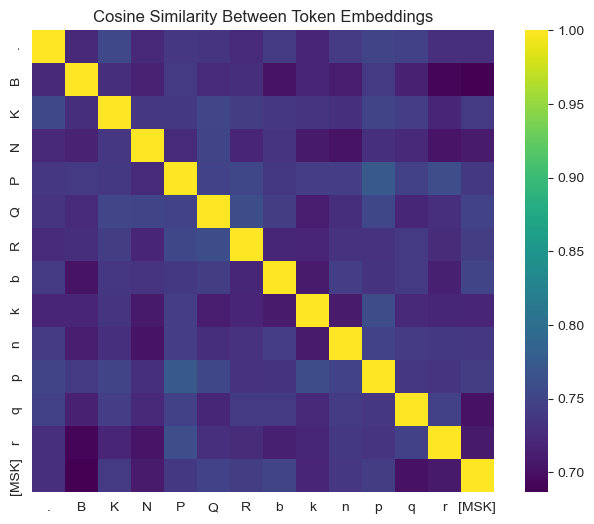

In [4]:
embedding_table = model.embedding_table.data
normed_embeds = F.normalize(embedding_table, dim=-1)
sim_matrix = torch.matmul(normed_embeds, normed_embeds.T)

plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix.cpu().numpy(), cmap='viridis', square=True, cbar=True,
            xticklabels=SimpleChessTokenizer().vocab + ['[MSK]'], yticklabels=SimpleChessTokenizer().vocab + ['[MSK]'])
plt.title("Cosine Similarity Between Token Embeddings")
plt.show()

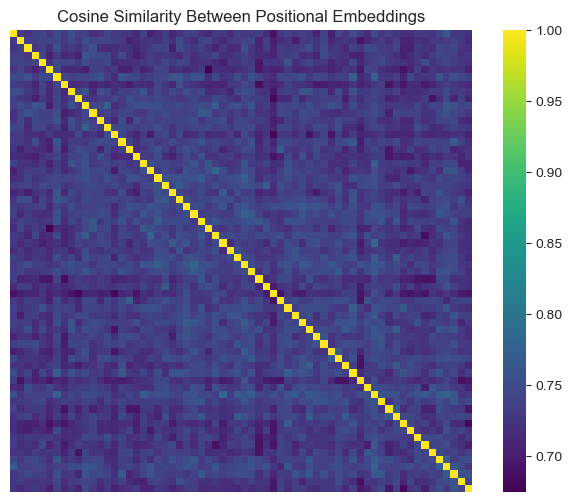

In [12]:
pos_embeddings = model.pos_embedding.data
normed_pos_embeds = F.normalize(pos_embeddings, dim=-1)
pos_sim_matrix = torch.matmul(normed_pos_embeds, normed_pos_embeds.T)

plt.figure(figsize=(8, 6))
sns.heatmap(pos_sim_matrix.cpu().numpy(), cmap='viridis', square=True, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title("Cosine Similarity Between Positional Embeddings")
plt.show()

In [5]:
pgn = PGNBoardHelper(Path('/Users/ray/Datasets/chess/Carlsen.pgn'))
pgn.get_game()
board_fens, next_board_fens = pgn.get_board_and_next_board_fens()

In [11]:
boards_in = []
for i, fen in enumerate(board_fens):
    board = chess.Board(fen)
    boards_in.append(board)

next_boards_in = []
for i, fen in enumerate(next_board_fens):
    board = chess.Board(fen)
    next_boards_in.append(board)

In [ ]:
from chess_gnn.utils import process_board_string
from chess_gnn.tokenizers import SimpleChessTokenizer

def prep_model_inputs(board: chess.Board, next_board: chess.Board):
    tokenizer = SimpleChessTokenizer()
    board = process_board_string(str(board))
    next_board = process_board_string(str(next_board))
    
    board_tokens = torch.Tensor(tokenizer.tokenize(board)).long().unsqueeze(0)
    next_board_tokens = torch.Tensor(tokenizer.tokenize(next_board)).long().unsqueeze(0)
    whose_move = torch.Tensor([int(not board.turn)]).long()
    
    return board_tokens, next_board, whose_move

In [ ]:
def bert_mask(model: ChessTransformer, board_tokens: torch.Tensor, next_board_tokens: torch.Tensor, whose_move: torch.Tensor):
    out = model.forward_mask(board_tokens, whose_move)
    mlm_preds = model.mlm_head(out['tokens'])
    
    return board_tokens, torch.argmax(mlm_preds, dim=-1), out['masked_token_labels']

In [ ]:
from chess_gnn.configuration import LocalHydraConfiguration
untrained_model = ChessBERT.from_hydra_configuration(LocalHydraConfiguration('/Users/ray/Projects/ChessGNN/configs/bert/training/bert.yaml'))

In [ ]:
tokenizer = SimpleChessTokenizer()
tokenizer.vocab

In [ ]:
labels, preds, masked = bert_mask(model, *prep_model_inputs(chess_board=boards_in[28]))

In [ ]:
einops.rearrange(torch.eq(labels, preds), "1 (h w) -> h w", h=8)

In [ ]:
torch.sum(~torch.eq(labels, preds))

In [ ]:
einops.rearrange(labels, "1 (h w) -> h w", h=8)

In [ ]:
einops.rearrange(preds, "1 (h w) -> h w", h=8)

In [ ]:
einops.rearrange(masked!=-100, "1 (h w) -> h w", h=8)

In [ ]:
torch.sum(masked!=-100)